In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score
import shap

In [2]:
# global var for region mapping
REGIONAL_HIERARCHY = {
    "usa - west coast": "north america",
    "usa - east coast": "north america",
    "usa - midwest": "north america",
    "usa - south": "north america",
    "western europe": "emea (europe, middle east, africa)",
    "eastern europe": "emea (europe, middle east, africa)",
    "nordics": "emea (europe, middle east, africa)",
    "southeast asia": "apac (asia-pacific)",
    "east asia": "apac (asia-pacific)",
    "south asia": "apac (asia-pacific)",
    "australia/new zealand": "apac (asia-pacific)",
    "middle east & north africa (mena)": "emea (europe, middle east, africa)",
    "sub-saharan africa": "emea (europe, middle east, africa)",
    "canada": "north america",
    "uk & ireland": "emea (europe, middle east, africa)",
    "north america": "global",
    "emea (europe, middle east, africa)": "global",
    "apac (asia-pacific)": "global",
    "latam (latin america)": "global",
    "global": "global"
}

In [3]:
historical_rfps_df = pd.read_csv('data/historical_rfps.csv')
lender_preferences_df = pd.read_csv('data/lender_preferences.csv')

In [4]:
historical_rfps_df.head()

,rfp_id,rfp_title,rfp_description,company_name,company_stage,company_founding_year,company_revenue_last_fy_usd,deal_size_usd,industry_sector,region,loan_type_requested,purpose_of_funds,submission_date,awarded_lender_id,funding_date,actual_funded_amount_usd,deal_status,number_of_applications_received,feedback_from_lender
0,RFP00001,Venture Debt for Seed Aerospace & Defense: Tor...,Seeking Venture Debt for Torres-Lee (Seed). Th...,Torres-Lee,Seed,2014.0,630923.0,35131801.0,Aerospace & Defense,North America,Venture Debt,Working Capital,2022-05-01,LDR0078,2022-06-25,32197086.0,Funded,11,NaN
1,RFP00002,Seed Round for Pre-Seed Media & Entertainment:...,"Seeking Seed Round for Hensley, Jimenez and Mi...","Hensley, Jimenez and Miller",Pre-Seed,1996.0,NaN,589842.0,Media & Entertainment,North America,Seed Round,Hiring Key Talent,2024-04-06,LDR0103,2024-08-13,476137.0,Funded,8,NaN
2,RFP00003,Revolving Credit Facility for Pre-Seed Educati...,Seeking Revolving Credit Facility for Henson L...,Henson Ltd,Pre-Seed,2015.0,704754.0,568035.0,Education,Western Europe,Revolving Credit Facility,Expansion (Domestic),2021-08-04,LDR0033,2021-10-03,466404.0,Funded,7,NaN
3,RFP00004,Project Finance for Startup Professional Servi...,"Seeking Project Finance for King, Hill and Mye...","King, Hill and Myers",Startup,2002.0,NaN,1452068.0,Professional Services,South Asia,Project Finance,Research and Development (R&D),2021-11-20,LDR0119,2022-01-28,1266622.0,Funded,12,NaN
4,RFP00005,Growth Equity for Startup Cybersecurity: Black...,Seeking Growth Equity for Blackwell-Mitchell (...,Blackwell-Mitchell,Startup,2022.0,21971354.0,1029195.0,Cybersecurity,North America,Growth Equity,Debt Refinancing,2022-08-28,LDR0114,2022-11-13,932076.0,Funded,11,NaN


In [5]:
lender_preferences_df.head()

,lender_id,lender_name,lender_type,preferred_deal_size_min_usd,preferred_deal_size_max_usd,preferred_industries,preferred_regions,preferred_loan_types,risk_appetite,specialization_notes,avg_funding_timeline_days,indicative_interest_rate_min_pct,indicative_interest_rate_max_pct,historical_success_rate_pct,contact_person,contact_email,website
0,LDR0001,"Jenkins, Jordan and Sutton Trust",Venture Capital,500000,2542187,Retail; Consumer Goods; Media & Entertainment,UK & Ireland,Growth Equity; Term Loan (Secured); Invoice Fi...,Medium-High,Specializes as a venture capital. Primary indu...,51,6.13,9.59,35.0,Brandon Finley,jshepherd@ramos-johnson.net,https://wilkinson.biz/
1,LDR0002,Parker PLC,Private Equity,25000000,94421436,HealthTech; AI & Machine Learning; Deep Tech,Sub-Saharan Africa; East Asia,Strategic Investment,Opportunistic,Specializes as a private equity. Primary indus...,51,NaN,NaN,26.0,Andrea Brown,mjohnson@roberts.com,https://www.jacobson.biz/
2,LDR0003,Tapia-Johnson Partners,Specialty Finance Company,500000,2728239,Deep Tech,APAC (Asia-Pacific),Series C+,Opportunistic,Specializes as a specialty finance company. Pr...,112,NaN,NaN,33.0,Kyle Trujillo,uwright@rojas.net,https://www.ward.net/
3,LDR0004,Williams-Chan Investments,Credit Union,50000,268667,Healthcare,LATAM (Latin America),Growth Equity; Convertible Note; Series C+,Medium,Specializes as a credit union. Primary industr...,142,NaN,NaN,70.0,Diana Terry,qpruitt@brown.com,http://coleman.com/
4,LDR0005,"Harrell, Hoffman and Carpenter",Credit Union,100000,670147,Agriculture & AgTech,Sub-Saharan Africa; South Asia,Project Finance,Low,Specializes as a credit union. Primary industr...,111,NaN,NaN,49.0,Dr. Martha Rice,christopherhurst@calhoun-ashley.com,http://torres.info/


### 1. Clean data: combine on preference with region mapping

In [6]:
def create_match(rfps_df, lender_df):
    """
    Given rfps and lender dataframe, creates a matching dataframe containing:
        lender_id, rfp_id, lender_name, rfp_title
    based on hard preference filters on deal_size, industry, region, load_type
    
    _params:
        rfps_df (pandas dataframe): historical rfps dataframe
        lender_df: lender preference dataframe
        
    _return:
        matched_rfps_to_lenders_df (pandas dataframe): matching dataframe that can be as a fact table
        unmatched rfps are not included in this dataframe
    """
    # helper function to process semicolon-separated strings into lists
    def parse_and_normalize_list_semicolon(text):
        if pd.isna(text):
            return []
        return [item.strip().lower() for item in str(text).split(';')]

    # helper function to get all sub-regions for a given region based on the hierarchy using BFS
    def get_all_sub_regions_iterative(region, hierarchy):
        all_regions = {region}
        queue = [region]
        # pre-build a reverse hierarchy for efficient lookup of children
        children_map = {}
        for child, parent in hierarchy.items():
            children_map.setdefault(parent, []).append(child)
        # BFS
        while queue:
            current_region = queue.pop(0)
            # get direct children of the current region
            direct_children = children_map.get(current_region, [])
            for child in direct_children:
                if child not in all_regions:
                    all_regions.add(child)
                    queue.append(child)
        return all_regions

    # process semi-colon multientry to lists in lender_preferences_df
    lender_preferences_df['preferred_industries_list'] = lender_preferences_df['preferred_industries'].apply(parse_and_normalize_list_semicolon)
    lender_preferences_df['preferred_regions_raw'] = lender_preferences_df['preferred_regions'].apply(parse_and_normalize_list_semicolon)
    lender_preferences_df['preferred_loan_types_list'] = lender_preferences_df['preferred_loan_types'].apply(parse_and_normalize_list_semicolon)

    # prepare for region matching with hierarchy
    lender_preferences_df['preferred_regions_expanded'] = lender_preferences_df['preferred_regions_raw'].apply(
        lambda regions: set().union(*[get_all_sub_regions_iterative(r, REGIONAL_HIERARCHY) for r in regions])
    )
    historical_rfps_df['industry_sector_normalized'] = historical_rfps_df['industry_sector'].str.lower().str.strip()
    historical_rfps_df['region_normalized'] = historical_rfps_df['region'].str.lower().str.strip()
    historical_rfps_df['loan_type_requested_normalized'] = historical_rfps_df['loan_type_requested'].str.lower().str.strip()
    matched_rfps_data = []

    # iterative match: apply all hard filers
    for index, lender in lender_preferences_df.iterrows():
        lender_id = lender['lender_id']
        min_deal_size = lender['preferred_deal_size_min_usd']
        max_deal_size = lender['preferred_deal_size_max_usd']
        preferred_industries = set(lender['preferred_industries_list'])
        preferred_regions = set(lender['preferred_regions_expanded']) # Use the expanded regions
        preferred_loan_types = set(lender['preferred_loan_types_list'])

        # deal size filter
        deal_size_filter = (historical_rfps_df['deal_size_usd'] >= min_deal_size) & \
                           (historical_rfps_df['deal_size_usd'] <= max_deal_size)
        # industry filter
        industry_filter = historical_rfps_df['industry_sector_normalized'].apply(lambda x: x in preferred_industries)
        # region filter
        region_filter = historical_rfps_df['region_normalized'].apply(lambda x: x in preferred_regions)
        # loan type filter
        loan_type_filter = historical_rfps_df['loan_type_requested_normalized'].apply(lambda x: x in preferred_loan_types)
        # combine all filters
        all_filters = deal_size_filter & industry_filter & region_filter & loan_type_filter

        # build result result df
        matched_rfps = historical_rfps_df[all_filters]
        for rfp_index, rfp in matched_rfps.iterrows():
            matched_rfps_data.append({
                'lender_id': lender_id,
                'rfp_id': rfp['rfp_id'],
                'lender_name': lender['lender_name'], # include lender name for better context
                'rfp_title': rfp['rfp_title'] # include rfp title for better context
            })

    matched_rfps_to_lenders_df = pd.DataFrame(matched_rfps_data)
    return matched_rfps_to_lenders_df

In [7]:
matched_rfps_to_lenders_df = create_match(historical_rfps_df, lender_preferences_df)
matched_rfps_to_lenders_df

,lender_id,rfp_id,lender_name,rfp_title
0,LDR0002,RFP00039,Parker PLC,Strategic Investment for Pre-Seed Deep Tech: M...
1,LDR0002,RFP00094,Parker PLC,Strategic Investment for Growth-Stage Deep Tec...
2,LDR0002,RFP00113,Parker PLC,Strategic Investment for Mature Deep Tech: Lop...
3,LDR0002,RFP00358,Parker PLC,Strategic Investment for Late-Stage Deep Tech:...
4,LDR0002,RFP00424,Parker PLC,Strategic Investment for Startup Deep Tech: Ji...
...,...,...,...,...
14950,LDR0199,RFP19518,"Caldwell, Walter and Gonzalez Ventures",Project Finance for Startup Gaming: Thompson Inc
14951,LDR0200,RFP02188,"Woods, Porter and Reynolds Ventures",Term Loan (Secured) for Early-Stage Profession...
14952,LDR0200,RFP11531,"Woods, Porter and Reynolds Ventures",Revolving Credit Facility for Mature Professio...
14953,LDR0200,RFP12913,"Woods, Porter and Reynolds Ventures",Revolving Credit Facility for Pre-Seed Profess...


In [8]:
# join back to get all columns
df_with_rfp_details = matched_rfps_to_lenders_df.merge(historical_rfps_df, on='rfp_id', how='left')
df_with_rfp_details.drop(columns=['rfp_title_x'], inplace=True)
df_with_rfp_details.rename(columns={'rfp_title_y': 'rfp_title'}, inplace=True)
# full analysis df
df_full_analysis = df_with_rfp_details.merge(
    # drop intermediate columns for better usability in analysis
    lender_preferences_df.drop(columns=['preferred_industries_list', 'preferred_regions_raw', 'preferred_loan_types_list', 'preferred_regions_expanded']),
    on='lender_id',
    how='left'
)
df_full_analysis.drop(columns=['lender_name_y'], inplace=True)
df_full_analysis.rename(columns={'lender_name_x': 'lender_name'}, inplace=True)

In [9]:
df_full_analysis

,lender_id,rfp_id,lender_name,rfp_title,rfp_description,company_name,company_stage,company_founding_year,company_revenue_last_fy_usd,deal_size_usd,...,preferred_loan_types,risk_appetite,specialization_notes,avg_funding_timeline_days,indicative_interest_rate_min_pct,indicative_interest_rate_max_pct,historical_success_rate_pct,contact_person,contact_email,website
0,LDR0002,RFP00039,Parker PLC,Strategic Investment for Pre-Seed Deep Tech: M...,Seeking Strategic Investment for Myers-Dickson...,Myers-Dickson,Pre-Seed,1993.0,NaN,64653836.0,...,Strategic Investment,Opportunistic,Specializes as a private equity. Primary indus...,51,NaN,NaN,26.0,Andrea Brown,mjohnson@roberts.com,https://www.jacobson.biz/
1,LDR0002,RFP00094,Parker PLC,Strategic Investment for Growth-Stage Deep Tec...,Seeking Strategic Investment for Brown-Brooks ...,Brown-Brooks,Growth-Stage,2006.0,470921.0,36315453.0,...,Strategic Investment,Opportunistic,Specializes as a private equity. Primary indus...,51,NaN,NaN,26.0,Andrea Brown,mjohnson@roberts.com,https://www.jacobson.biz/
2,LDR0002,RFP00113,Parker PLC,Strategic Investment for Mature Deep Tech: Lop...,Seeking Strategic Investment for Lopez-Owen (M...,Lopez-Owen,Mature,2009.0,14011055.0,89992779.0,...,Strategic Investment,Opportunistic,Specializes as a private equity. Primary indus...,51,NaN,NaN,26.0,Andrea Brown,mjohnson@roberts.com,https://www.jacobson.biz/
3,LDR0002,RFP00358,Parker PLC,Strategic Investment for Late-Stage Deep Tech:...,Seeking Strategic Investment for Smith Ltd (La...,Smith Ltd,Late-Stage,2019.0,5870450.0,35181244.0,...,Strategic Investment,Opportunistic,Specializes as a private equity. Primary indus...,51,NaN,NaN,26.0,Andrea Brown,mjohnson@roberts.com,https://www.jacobson.biz/
4,LDR0002,RFP00424,Parker PLC,Strategic Investment for Startup Deep Tech: Ji...,Seeking Strategic Investment for Jimenez PLC (...,Jimenez PLC,Startup,2008.0,452939.0,47605205.0,...,Strategic Investment,Opportunistic,Specializes as a private equity. Primary indus...,51,NaN,NaN,26.0,Andrea Brown,mjohnson@roberts.com,https://www.jacobson.biz/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14950,LDR0199,RFP19518,"Caldwell, Walter and Gonzalez Ventures",Project Finance for Startup Gaming: Thompson Inc,Seeking Project Finance for Thompson Inc (Star...,Thompson Inc,Startup,2010.0,NaN,20504406.0,...,Strategic Investment; Project Finance,Medium-Low,Specializes as a investment fund. Primary indu...,73,NaN,NaN,15.0,Leah Ware,dylan45@jordan.com,http://kramer.com/
14951,LDR0200,RFP02188,"Woods, Porter and Reynolds Ventures",Term Loan (Secured) for Early-Stage Profession...,Seeking Term Loan (Secured) for Collins PLC (E...,Collins PLC,Early-Stage,2021.0,136268.0,7364409.0,...,Term Loan (Secured); Revolving Credit Facility,Low,Specializes as a private equity. Primary indus...,71,3.97,5.71,68.0,James Dunn,spencerbrenda@hahn-kim.com,http://www.summers.biz/
14952,LDR0200,RFP11531,"Woods, Porter and Reynolds Ventures",Revolving Credit Facility for Mature Professio...,Seeking Revolving Credit Facility for Newman P...,Newman PLC,Mature,1995.0,0.0,10251457.0,...,Term Loan (Secured); Revolving Credit Facility,Low,Specializes as a private equity. Primary indus...,71,3.97,5.71,68.0,James Dunn,spencerbrenda@hahn-kim.com,http://www.summers.biz/
14953,LDR0200,RFP12913,"Woods, Porter and Reynolds Ventures",Revolving Credit Facility for Pre-Seed Profess...,Seeking Revolving Credit Facility for Miller G...,Miller Group,Pre-Seed,2013.0,0.0,15264354.0,...,Term Loan (Secured); Revolving Credit Facility,Low,Specializes as a private equity. Primary indus...,71,3.97,5.71,68.0,James Dunn,spencerbrenda@hahn-kim.com,http://www.summers.biz/


### 2. EDA

In [10]:
df_full_analysis['deal_status'].unique()

array(['Funded', 'Initial Screening Passed', 'Awaiting Signature',
       'Term Sheet Issued', 'Withdrawn by Applicant', 'Pending Review',
       'Due Diligence', 'Declined by Lenders'], dtype=object)

In [11]:
funded_rfps = df_full_analysis[df_full_analysis['deal_status'].str.lower() == 'funded']

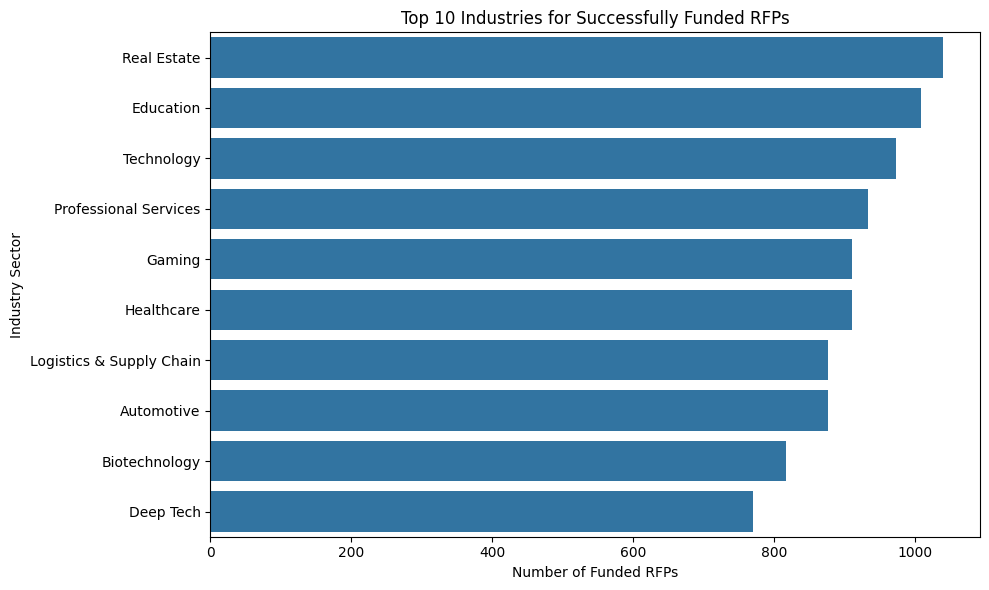

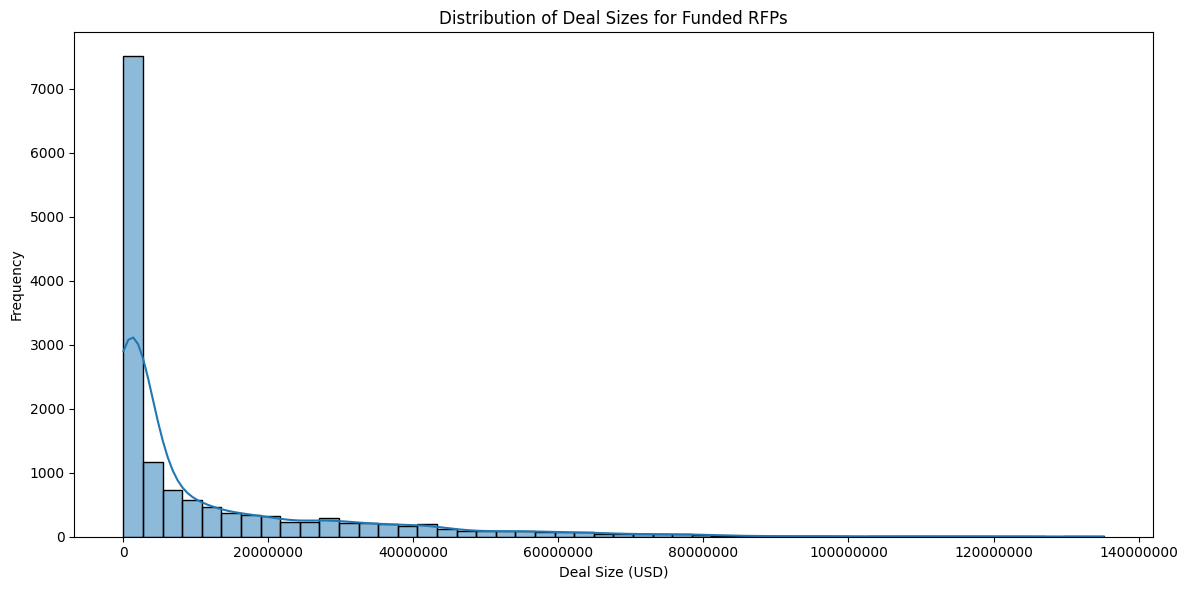

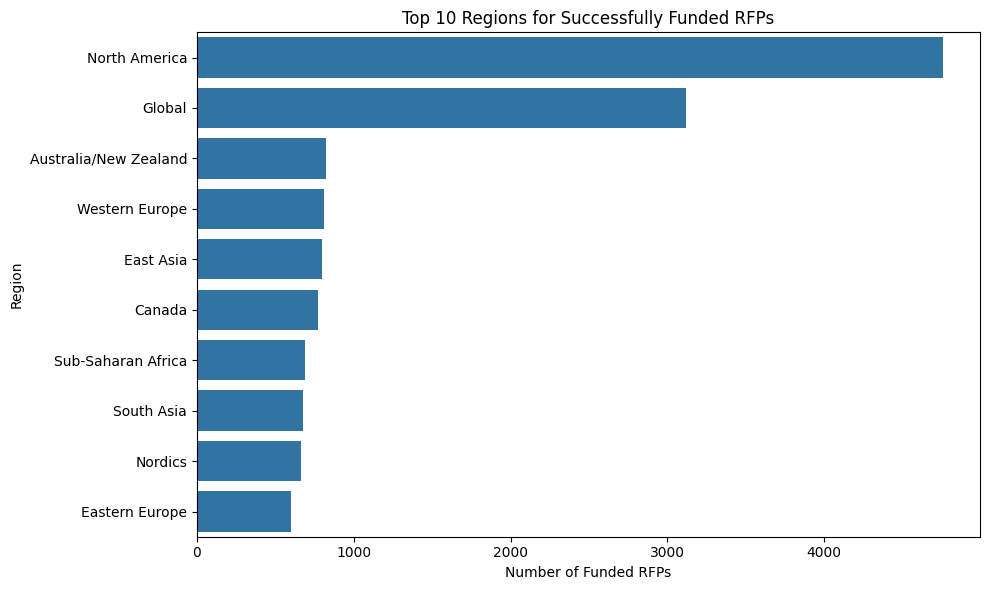

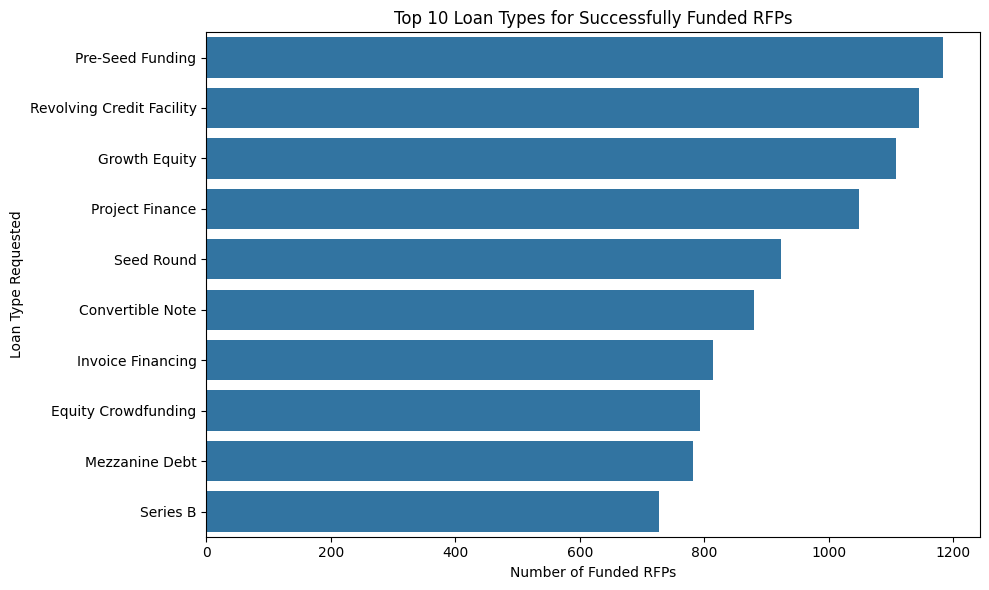

In [12]:
"""
Characteristics of successfully funded RFPs (e.g., common industries, deal sizes, regions, loan types).
"""
# common industries
plt.figure(figsize=(10, 6))
sns.countplot(
    y='industry_sector',
    data=funded_rfps,
    order=funded_rfps['industry_sector'].value_counts().index[:10],
)
plt.title('Top 10 Industries for Successfully Funded RFPs')
plt.xlabel('Number of Funded RFPs')
plt.ylabel('Industry Sector')
plt.tight_layout()
plt.savefig('assets/funded_rfps_top_industries.png')
plt.show()
# deal sizes
plt.figure(figsize=(12, 6))
sns.histplot(funded_rfps['deal_size_usd'], bins=50, kde=True)
plt.title('Distribution of Deal Sizes for Funded RFPs')
plt.xlabel('Deal Size (USD)')
plt.ylabel('Frequency')
plt.ticklabel_format(style='plain', axis='x')
plt.tight_layout()
plt.savefig('assets/funded_rfps_deal_sizes.png')
plt.show()
# regions
plt.figure(figsize=(10, 6))
sns.countplot(y='region', data=funded_rfps, order=funded_rfps['region'].value_counts().index[:10])
plt.title('Top 10 Regions for Successfully Funded RFPs')
plt.xlabel('Number of Funded RFPs')
plt.ylabel('Region')
plt.tight_layout()
plt.savefig('assets/funded_rfps_regions.png')
plt.show()
# loan types
plt.figure(figsize=(10, 6))
sns.countplot(y='loan_type_requested', data=funded_rfps, order=funded_rfps['loan_type_requested'].value_counts().index[:10])
plt.title('Top 10 Loan Types for Successfully Funded RFPs')
plt.xlabel('Number of Funded RFPs')
plt.ylabel('Loan Type Requested')
plt.tight_layout()
plt.savefig('assets/funded_rfps_loan_types.png')
plt.show()

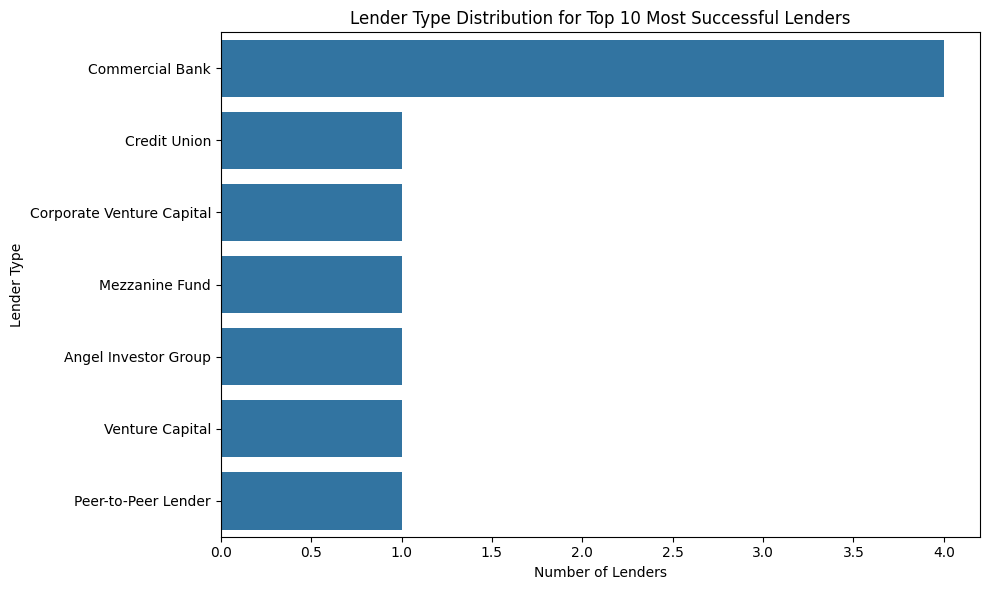

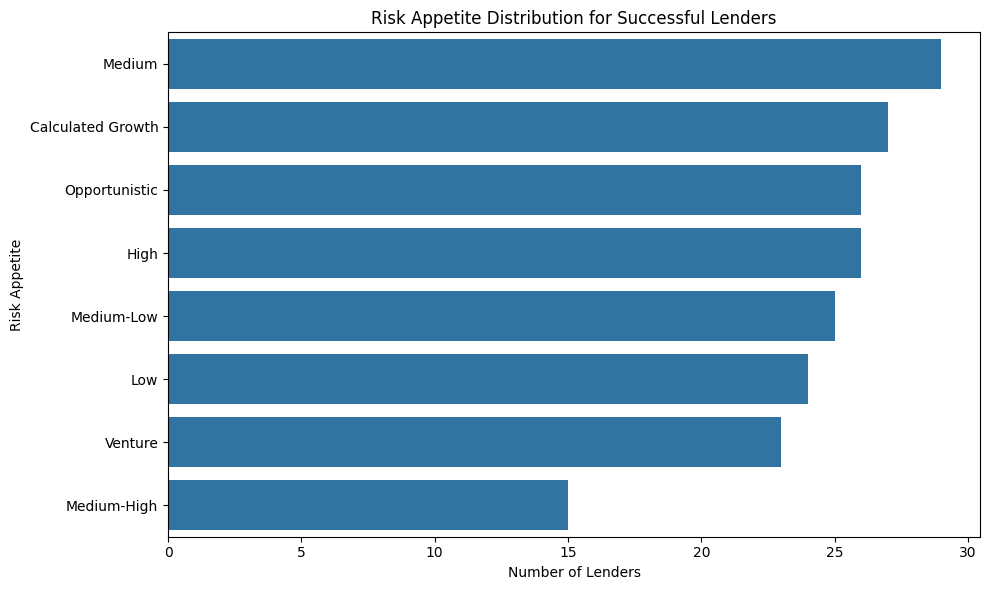

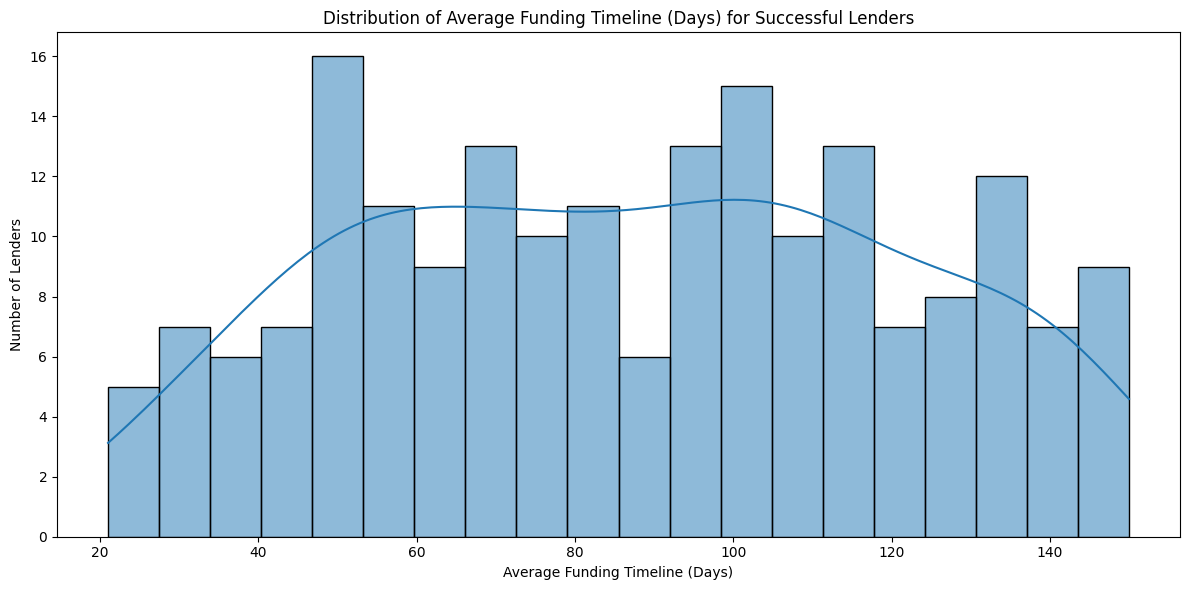

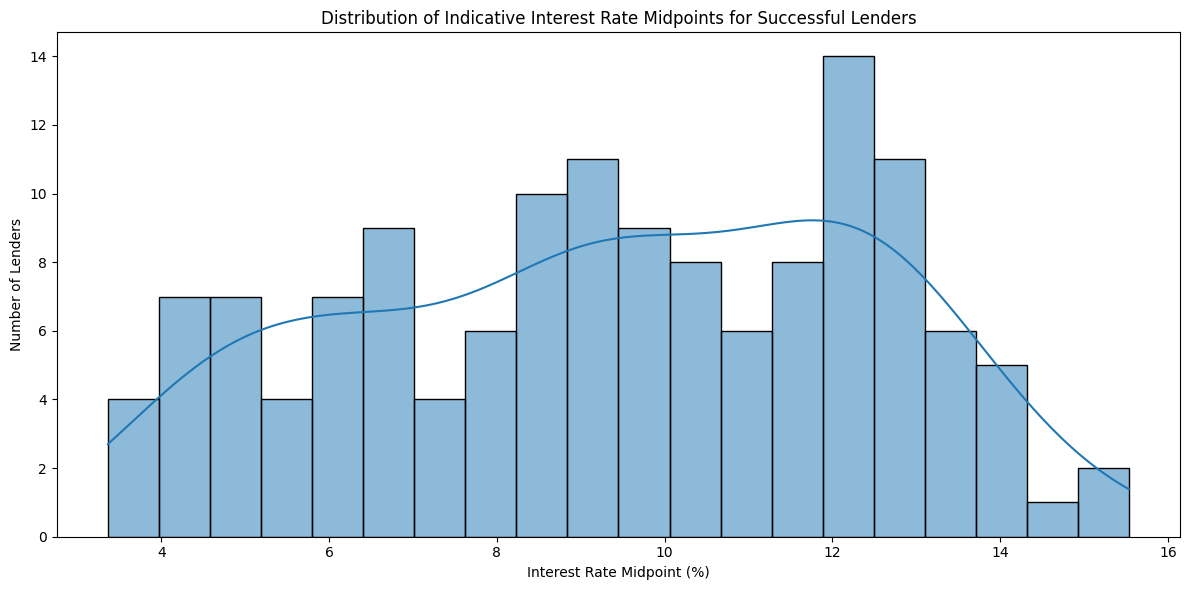

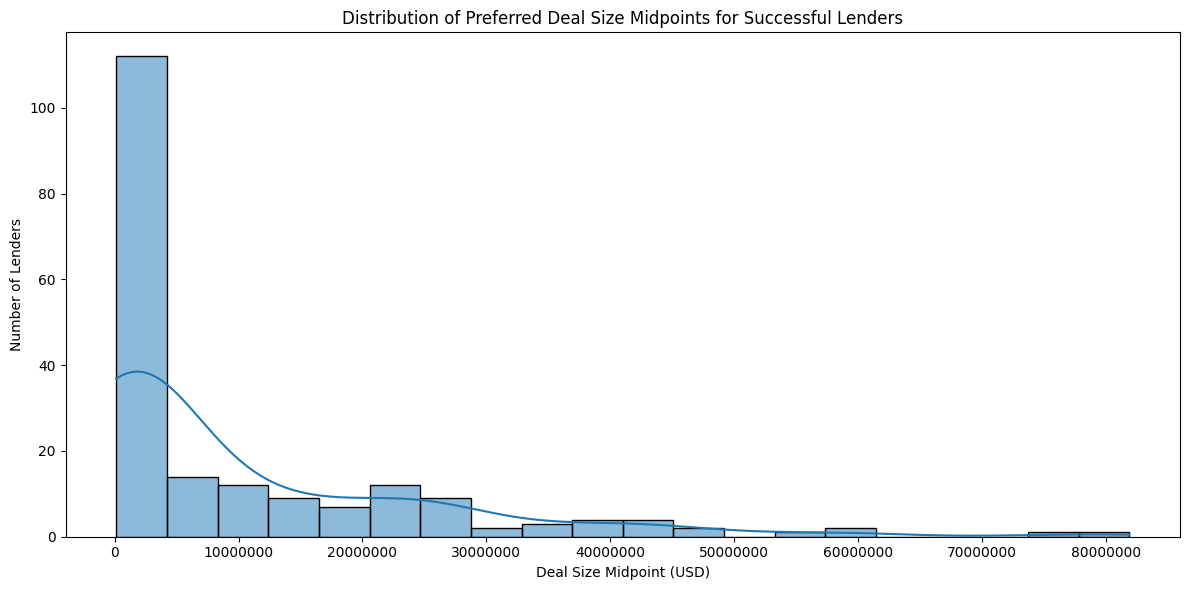

In [13]:
"""
Profiles of active and successful lenders.
"""
# build combined successful lender df
successful_lender_counts = funded_rfps['awarded_lender_id'].value_counts()
successful_lenders_df = pd.DataFrame(successful_lender_counts).reset_index()
successful_lenders_df.columns = ['lender_id', 'funded_rfp_count']
lender_preferences_for_profile_merge = lender_preferences_df.drop(columns=[
    'preferred_industries_list',
    'preferred_regions_raw',
    'preferred_loan_types_list',
    'preferred_regions_expanded'
], errors='ignore')
successful_lenders_profile = successful_lenders_df.merge(
    lender_preferences_for_profile_merge,
    on='lender_id', how='left'
)

# deal size processing for analysis
successful_lenders_profile['preferred_deal_size_midpoint'] = (successful_lenders_profile['preferred_deal_size_min_usd'] + successful_lenders_profile['preferred_deal_size_max_usd']) / 2
successful_lenders_profile['preferred_deal_size_width'] = successful_lenders_profile['preferred_deal_size_max_usd'] - successful_lenders_profile['preferred_deal_size_min_usd']
# indicative interest rate processing for analysis
successful_lenders_profile['indicative_interest_rate_midpoint'] = (successful_lenders_profile['indicative_interest_rate_min_pct'] + successful_lenders_profile['indicative_interest_rate_max_pct']) / 2
successful_lenders_profile['indicative_interest_rate_width'] = successful_lenders_profile['indicative_interest_rate_max_pct'] - successful_lenders_profile['indicative_interest_rate_min_pct']

# lender type distribution
plt.figure(figsize=(10, 6))
sns.countplot(y='lender_type', data=successful_lenders_profile.nlargest(10, 'funded_rfp_count'), order=successful_lenders_profile.nlargest(10, 'funded_rfp_count')['lender_type'].value_counts().index)
plt.title('Lender Type Distribution for Top 10 Most Successful Lenders')
plt.xlabel('Number of Lenders')
plt.ylabel('Lender Type')
plt.tight_layout()
plt.savefig('assets/lenders_top_types.png')
plt.show()

# risk appetite
plt.figure(figsize=(10, 6))
sns.countplot(y='risk_appetite', data=successful_lenders_profile, order=successful_lenders_profile['risk_appetite'].value_counts().index)
plt.title('Risk Appetite Distribution for Successful Lenders')
plt.xlabel('Number of Lenders')
plt.ylabel('Risk Appetite')
plt.tight_layout()
plt.savefig('assets/lenders_risk_appetite.png')
plt.show()

# funding timeline
plt.figure(figsize=(12, 6))
sns.histplot(successful_lenders_profile['avg_funding_timeline_days'].dropna(), bins=20, kde=True)
plt.title('Distribution of Average Funding Timeline (Days) for Successful Lenders')
plt.xlabel('Average Funding Timeline (Days)')
plt.ylabel('Number of Lenders')
plt.tight_layout()
plt.savefig('assets/lenders_funding_timeline.png')
plt.show()

# interest rate
plt.figure(figsize=(12, 6))
sns.histplot(successful_lenders_profile['indicative_interest_rate_midpoint'].dropna(), bins=20, kde=True)
plt.title('Distribution of Indicative Interest Rate Midpoints for Successful Lenders')
plt.xlabel('Interest Rate Midpoint (%)')
plt.ylabel('Number of Lenders')
plt.tight_layout()
plt.savefig('assets/lenders_interest_rates.png')
plt.show()

# deal size
plt.figure(figsize=(12, 6))
sns.histplot(successful_lenders_profile['preferred_deal_size_midpoint'].dropna(), bins=20, kde=True)
plt.title('Distribution of Preferred Deal Size Midpoints for Successful Lenders')
plt.xlabel('Deal Size Midpoint (USD)')
plt.ylabel('Number of Lenders')
plt.ticklabel_format(style='plain', axis='x')
plt.tight_layout()
plt.savefig('assets/lenders_deal_size_midpoints.png')
plt.show()


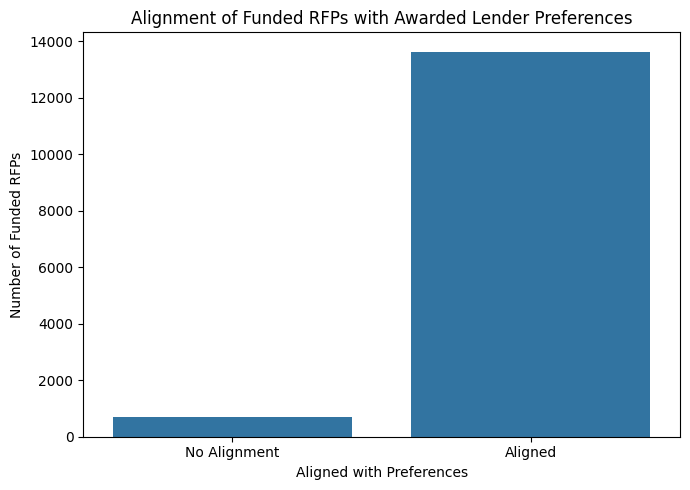

In [14]:
"""
The relationship between lender preferences and RFP funding outcomes.
You should find that a significant portion of funded RFPs have characteristics that align well with their awarded
lender's preferences.
"""
# (rfp_id, awarded_lender_id) for successful funded matching
matched_rfps_to_lenders_df['match_pair'] = matched_rfps_to_lenders_df['rfp_id'] + '_' + matched_rfps_to_lenders_df['lender_id']
matched_pairs_set = set(matched_rfps_to_lenders_df['match_pair'])

funded_rfps_analysis = df_full_analysis[df_full_analysis['deal_status'].str.lower() == 'funded'].copy()
# handle potential NaN awarded_lender_id before string concatenation
funded_rfps_analysis['awarded_lender_id_str'] = funded_rfps_analysis['awarded_lender_id'].fillna('NOT_AWARDED').astype(str)
funded_rfps_analysis['awarded_pair'] = funded_rfps_analysis['rfp_id'] + '_' + funded_rfps_analysis['awarded_lender_id_str']

# apply filter
funded_rfps_analysis['aligned_with_preferences'] = funded_rfps_analysis['awarded_pair'].apply(
    lambda x: x in matched_pairs_set if x.split('_')[1] != 'NOT_AWARDED' else False
)

plt.figure(figsize=(7, 5))
sns.countplot(x='aligned_with_preferences', data=funded_rfps_analysis)
plt.title('Alignment of Funded RFPs with Awarded Lender Preferences')
plt.xlabel('Aligned with Preferences')
plt.ylabel('Number of Funded RFPs')
plt.xticks(ticks=[0, 1], labels=['No Alignment', 'Aligned'])
plt.tight_layout()
plt.savefig('assets/preference_alignment.png')
plt.show()

### 3. Find best lenders for given RFP (use service or manually)

In [15]:
# get df for ml
df_ml = matched_rfps_to_lenders_df.merge(historical_rfps_df, on='rfp_id', how='left')
df_ml = df_ml.drop(columns=['industry_sector_normalized', 'region_normalized', 'loan_type_requested_normalized'], errors='ignore')
lender_features_for_ml = lender_preferences_df.drop(columns=[
    'preferred_industries_list', 'preferred_regions_raw', 'preferred_loan_types_list', 'preferred_regions_expanded'
], errors='ignore')
df_ml = df_ml.merge(lender_features_for_ml, on='lender_id', how='left')

# preprocess and feature selection for ml
df_ml['is_awarded_match'] = ((df_ml['deal_status'].str.lower() == 'funded') &
                              (df_ml['lender_id'] == df_ml['awarded_lender_id'])).astype(int)
rfp_numerical_features = ['company_revenue_last_fy_usd', 'deal_size_usd', 'number_of_applications_received']
rfp_categorical_features = ['company_stage', 'industry_sector', 'region', 'loan_type_requested', 'purpose_of_funds']

lender_numerical_features = ['preferred_deal_size_min_usd', 'preferred_deal_size_max_usd',
                             'avg_funding_timeline_days', 'indicative_interest_rate_min_pct',
                             'indicative_interest_rate_max_pct', 'historical_success_rate_pct']
lender_categorical_features = ['lender_type', 'risk_appetite']

all_features = rfp_numerical_features + rfp_categorical_features + \
               lender_numerical_features + lender_categorical_features

In [16]:
# more processing to prepare for ml
X = df_ml[all_features].copy()
y = df_ml['is_awarded_match']

# handle null in categorical columns
for col in rfp_categorical_features + lender_categorical_features:
    if X[col].isnull().sum() > 0:
        X[col] = X[col].fillna('missing')
        
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [17]:
# check the need for imbalance handling
neg_count = y_train.value_counts()[0]
pos_count = y_train.value_counts()[1]
scale_pos_weight = neg_count / pos_count if pos_count != 0 else 1
print(f"\nClass distribution in training set: Negative={neg_count}, Positive={pos_count}")
print(f"Calculated scale_pos_weight: {scale_pos_weight:.2f}")


Class distribution in training set: Negative=3618, Positive=8346
Calculated scale_pos_weight: 0.43


In [18]:
# impuatation processor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
        ]), rfp_numerical_features + lender_numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), rfp_categorical_features + lender_categorical_features)
    ])

# model pipeline
xgb_model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('classifier', xgb.XGBClassifier(
                                         scale_pos_weight=scale_pos_weight,
                                         random_state=42,
                                     ))])
xgb_model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['company_revenue_last_fy_usd',
                                                   'deal_size_usd',
                                                   'number_of_applications_received',
                                                   'preferred_deal_size_min_usd',
                                                   'preferred_deal_size_max_usd',
                                                   'avg_funding_timeline_days',
                                                   'indicative_interest_rate_min_pct',
                                                   'indicative_...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [19]:
# quick evaluation
y_pred = xgb_model_pipeline.predict(X_test)
y_pred_proba = xgb_model_pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       905
           1       0.97      0.93      0.95      2086

    accuracy                           0.93      2991
   macro avg       0.91      0.93      0.92      2991
weighted avg       0.93      0.93      0.93      2991

ROC AUC Score: 0.9837


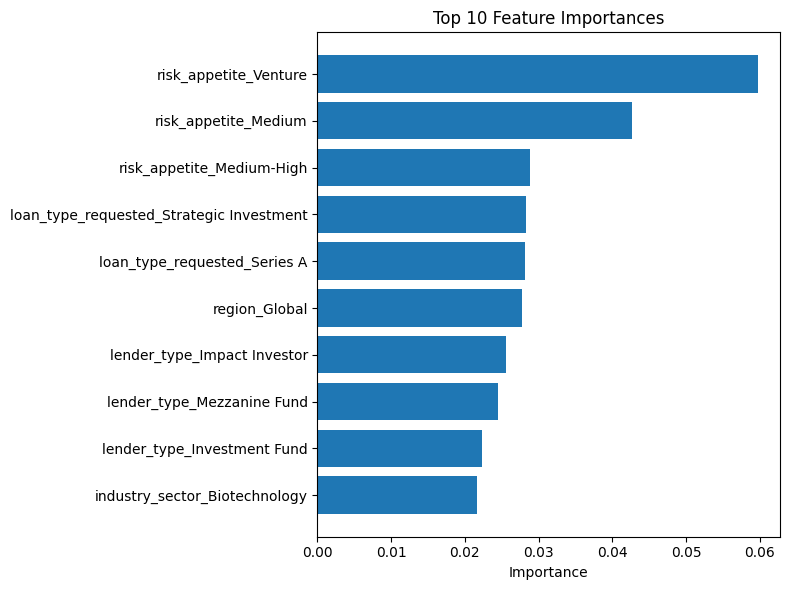

In [20]:
# analyze features: feature importances
fitted_preprocessor = xgb_model_pipeline.named_steps['preprocessor']
numerical_feature_names_out = rfp_numerical_features + lender_numerical_features
categorical_feature_names_out = fitted_preprocessor.named_transformers_['cat'].get_feature_names_out(rfp_categorical_features + lender_categorical_features)
all_feature_names_for_model = list(numerical_feature_names_out) + list(categorical_feature_names_out)
importance_scores = xgb_model_pipeline.named_steps['classifier'].feature_importances_

feature_importances_df = pd.DataFrame({
    'Feature': all_feature_names_for_model,
    'Importance': importance_scores
})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# visualize
top_n = 10
top_features = feature_importances_df.head(top_n)
plt.figure(figsize=(8, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel("Importance")
plt.title(f"Top {top_n} Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('assets/ml_feature_importances.png')
plt.show()

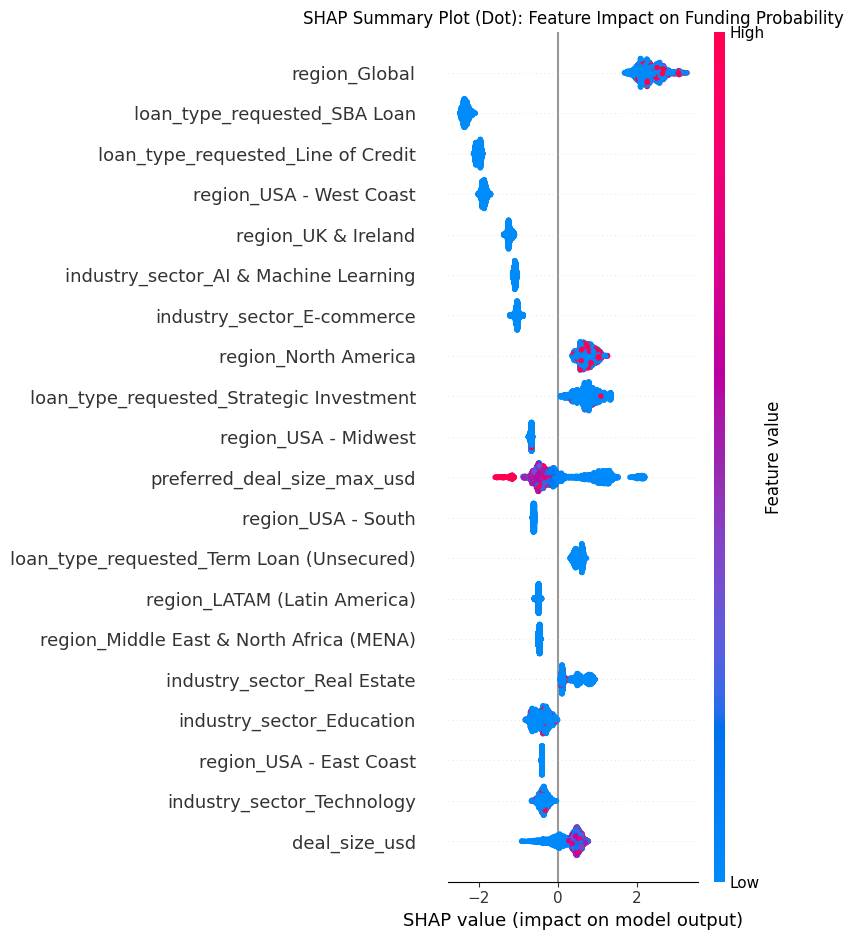

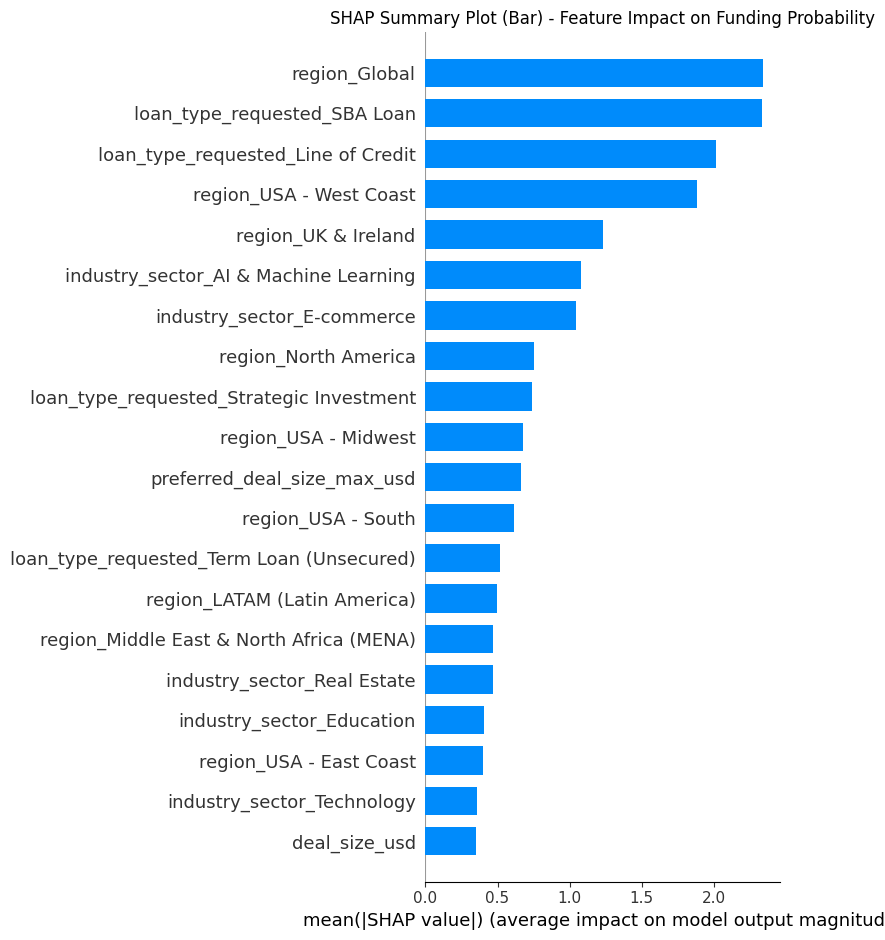

In [26]:
# analyze features: shap
# prep data for shap using test data
X_test_transformed = xgb_model_pipeline.named_steps['preprocessor'].transform(X_test)
X_test_transformed_dense = X_test_transformed.toarray() if hasattr(X_test_transformed, "toarray") else X_test_transformed
# shap
explainer = shap.TreeExplainer(xgb_model_pipeline.named_steps['classifier'])
shap_values = explainer.shap_values(X_test_transformed_dense)

if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_values_for_positive_class = shap_values[1]
else:
    shap_values_for_positive_class = shap_values
shap_df_for_plot = pd.DataFrame(X_test_transformed_dense, columns=all_feature_names_for_model)

# summary dot plot
plt.figure(figsize=(10, 7)) 
shap.summary_plot(shap_values_for_positive_class, shap_df_for_plot, show=False)
plt.title("SHAP Summary Plot (Dot): Feature Impact on Funding Probability")
plt.tight_layout()
plt.savefig('assets/ml_shap_dot.png')
plt.show()

# summary bar plot
plt.figure(figsize=(10, 7)) 
shap.summary_plot(shap_values_for_positive_class, shap_df_for_plot, plot_type="bar", show=False)
plt.title("SHAP Summary Plot (Bar) - Feature Impact on Funding Probability")
plt.tight_layout()
plt.savefig('assets/ml_shap_bar.png')
plt.show()

In [ ]:
# function to recommend lenders for given RFP
def recommend_lenders(rfp_data_series, top_n=5):
    """
    recommends top N lenders for a given RFP based on hard filters and XGBoost prediction

    _params:
        rfp_data_series (pandas series): pandas series containing characteristics of the new RFP
        top_n (int): number of top lenders to recommend

    _return:
        pandas dataframe: pandas dataframe with recommended lenders, their predicted probability
                      and key lender profile information, ranked by probability
                      returns empty dataframe if no lenders meet hard filters
    """
    
    # apply hard filters to find eligible lender
    rfp_deal_size = rfp_data_series['deal_size_usd']
    # null handling
    rfp_industry_normalized = str(rfp_data_series['industry_sector']).lower().strip() if pd.notna(rfp_data_series['industry_sector']) else 'missing'
    rfp_region_normalized = str(rfp_data_series['region']).lower().strip() if pd.notna(rfp_data_series['region']) else 'missing'
    rfp_loan_type_normalized = str(rfp_data_series['loan_type_requested']).lower().strip() if pd.notna(rfp_data_series['loan_type_requested']) else 'missing'
    eligible_lenders_list = []
    for idx, lender in lender_preferences_df.iterrows():
        min_deal_size = lender['preferred_deal_size_min_usd']
        max_deal_size = lender['preferred_deal_size_max_usd']
        preferred_industries = set(lender['preferred_industries_list'])
        preferred_regions = set(lender['preferred_regions_expanded'])
        preferred_loan_types = set(lender['preferred_loan_types_list'])
        if not (min_deal_size <= rfp_deal_size <= max_deal_size):
            continue
        if rfp_industry_normalized not in preferred_industries:
            continue
        if rfp_region_normalized not in preferred_regions:
            continue
        if rfp_loan_type_normalized not in preferred_loan_types:
            continue
        eligible_lenders_list.append(lender['lender_id'])
    if not eligible_lenders_list:
        print("No lenders found that meet all hard-filtered preferences for this RFP.")
        return pd.DataFrame()

    # prepare input data for ml
    eligible_lenders_df = lender_preferences_df[lender_preferences_df['lender_id'].isin(eligible_lenders_list)].copy()
    rfp_data_for_pred = rfp_data_series[rfp_numerical_features + rfp_categorical_features].to_frame().T
    combined_features_for_pred = pd.concat([rfp_data_for_pred] * len(eligible_lenders_df), ignore_index=True)
    combined_features_for_pred[lender_numerical_features + lender_categorical_features] = eligible_lenders_df[lender_numerical_features + lender_categorical_features].reset_index(drop=True)
    combined_features_for_pred = combined_features_for_pred[all_features]
    # ml inference
    predicted_probabilities = xgb_model_pipeline.predict_proba(combined_features_for_pred)[:, 1]
    
    # format for output
    eligible_lenders_df['predicted_funding_probability'] = predicted_probabilities
    ranked_lenders = eligible_lenders_df.sort_values(by='predicted_funding_probability', ascending=False)
    display_cols = ['lender_name', 'lender_type', 'predicted_funding_probability',
                    'historical_success_rate_pct', 'preferred_deal_size_min_usd',
                    'preferred_deal_size_max_usd', 'risk_appetite']
    
    return ranked_lenders[display_cols].head(top_n)

In [ ]:
# example remmendation
sample_rfp_id = 'RFP00005'
sample_rfp_data = historical_rfps_df[historical_rfps_df['rfp_id'] == sample_rfp_id].iloc[0]

print(f"\nRecommending lenders for RFP: {sample_rfp_data['rfp_title']} (ID: {sample_rfp_id})")
recommended_lenders = recommend_lenders(sample_rfp_data)
recommended_lenders

### 4. Strategy questions

#### Based on your analysis, what are the top 3-5 factors or characteristics that appear to correlate with an RFP being successfully funded?


The analysis below integrates both RFP and lender characteristics to provide a more holistic view of what drives funding success. However, we can narrow the scope to focus solely on RFP attributes based on business needs.
- At a minimum, hard filters must be met: there should be at least one lender whose preferred deal size, industry, region (with hierarchy), and loan type align with the RFP profile.
- Beyond the hard filters, the top predictive features include:
    - Lender risk appetite (Venture): RFPs matched with lenders who have a venture-level risk appetite are more likely to be funded, suggesting higher tolerance for risk is a key success factor.
    - Region (Global): RFPs targeting a global region show higher funding probability, consistently ranked as a top factor across both feature importance and SHAP impact.
    - Loan Type (Strategic Investment): Strategic investment requests are positively associated with funding success in both rankings and model explanations.

Many additional features also contribute meaningfully, and we can tailor our focus depending on the specific use case or decision context.

#### Why did you choose that particular approach and model? Weigh in potential alternatives.


The first step involves hard filtering based on lender preferences as instructed. After applying these filters, I structured the analysis as a machine learning classification task, using both RFP and lender attributes as inputs and modeling the output as whether an RFP was successfully funded (with the assumption that successful fund means both status is funded and there's an awarded lender associated).

Some approaches I considered include rule-based engine and heuristic ranking algorithms, but I choose machine learning, in particular XGBoost, due to its flexibility and potential in understanding nuances in complicated data. In terms of ML model selection, I choose XGBoost for its perforamnce, robustness, interpretability, and ease of development. 

#### How would you improve this going forward?

For deeper analysis, the most promising area would be incorporating natural language features like rfp_description and specialization_notes, and I’ll expand on in the next section. Beyond that, I would explore more advanced feature engineering, including time-series patterns and some more nuanced ratio calculations. The machine learning model can also be further improved through techniques like hyperparameter tuning, cross-validation.

In terms of business needs and production uses, all the code above can be made more modular for reusability and scalability. For example, using object-oriented structure and exposing key components like model inference via APIs to improve reusability and integration with other systems. While not fully demonstrated here, robust error handling and data validation are also critical for deployment. In a production setting, I would implement a structured pipeline to catch and log exceptions and validate data inputs at each stage to ensure stability and maintainability.

#### Bonus: How might the specialization_notes in the lender data be used to improve a matching algorithm? What are the challenges in using this field?

Proper handling of this column using natural language processing techniques could reveal some niche preferences and exclusions that allows deeper contextual understanding into lender preferences. Additionally, it can be combined with rfp_description via semantic similarity or LLM APIs to further help accurate RFP recommendation. 

If using traditional NLP approaches, some challenges include proper cleaning and preprocessing to retain meaningful content while filtering out noise.

If using LLM-based approaches, we would have a more robust handling of unstructured language and better semantic understanding. However, we need to carefully setup validation checks to mitigate halluciation and perform data protections to safeguard sensitive infomration.

In [ ]:
historical_rfps_df['rfp_description'][100]

In [ ]:
lender_preferences_df['specialization_notes'][100]